Load in FlyCircuit data from files we scraped from their website

Chiang et al. Current Biology 21(1), 2011
"Three-Dimensional Reconstruction of Brain-wide Wiring Networks
in Drosophila at Single-Cell Resolution"

http://www.cell.com/current-biology/pdf/S0960-9822(10)01522-8.pdf

http://www.cell.com/cms/attachment/2021742387/2041573538/mmc1.pdf

http://flycircuit.tw/


Python refs:

http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html

https://alleninstitute.github.io/AllenSDK/cell_types.html
https://alleninstitute.github.io/AllenSDK/connectivity.html
https://alleninstitute.github.io/AllenSDK/allensdk.core.html#module-allensdk.core.swc

https://alleninstitute.github.io/AllenSDK/_static/examples/nb/mouse_connectivity.html#Generating-a-Projection-Matrix

https://bitbucket.org/btorb/btmorph

http://neuromorpho.org/
http://neuromorpho.org/SomaFormat.html









In [1]:
# 
# modified version of allen's swc parser that can deal
# with some inconsistencies in the fly circuit swc filse
#

import allensdk.core.swc as abi

# modified from allen sdk swc loader
def load_swc(file_name, columns="NOT_USED", numeric_columns="NOT_USED"):
    compartments = []
    line_num = 1
    somafound = False
    try:
        with open(file_name, "r") as f:
            for line in f:
                # remove comments
                if line.lstrip().startswith('#'):
                    continue
                # remove leading spaces
                line = line.lstrip();
                
                # read values. expected SWC format is:
                #   ID, type, x, y, z, rad, parent
                # x, y, z and rad are floats. the others are ints
                toks = line.split(' ')
                vals = abi.Compartment({
                    abi.NODE_ID: int(toks[0]),
                    abi.NODE_TYPE: int(toks[1]),
                    abi.NODE_X: float(toks[2]),
                    abi.NODE_Y: float(toks[3]),
                    abi.NODE_Z: float(toks[4]),
                    abi.NODE_R: float(toks[5]),
                    abi.NODE_PN: int(toks[6].rstrip())
                })
                
                # remap types from flycircuit to allen
                if (vals[abi.NODE_TYPE] == 4):
                    vals[abi.NODE_TYPE] = abi.Morphology.SOMA
                elif (vals[abi.NODE_TYPE] == 1):
                    vals[abi.NODE_TYPE] = abi.Morphology.AXON
                elif (vals[abi.NODE_TYPE] == 6):
                    vals[abi.NODE_TYPE] = abi.Morphology.APICAL_DENDRITE

                # clean some bad data from flycircuit with multiple soma?           
                if (vals[abi.NODE_TYPE] == abi.Morphology.SOMA) and (vals[abi.NODE_PN]<0):
                    if somafound is True:
                        vals[abi.NODE_TYPE] = 6
                        print("Warning: duplicate soma found in "+file_name)
                        print(toks)
                    else:
                        somafound = True 
  
                # store this compartment
                compartments.append(vals)
                # increment line number (used for error reporting only)
                line_num += 1
    except ValueError:
        err = "File not recognized as valid SWC file.\n"
        err += "Problem parsing line %d\n" % line_num
        if line is not None:
            err += "Content: '%s'\n" % line
        raise IOError(err)

    return abi.Morphology(compartment_list=compartments)


In [25]:
#
# process the flycircuit swc files using the modified allen sdk above 
# and then save them out again.
#
# apply an affine warping that aligns them with the virtual fly brain
#  (http://www.virtualflybrain.org/) FCWB atlas coordinate system
#

import os
import sys
import numpy as np
from ipywidgets import FloatProgress
from IPython.display import display

# transformation estimated to warp flycircuit swcs to FCWB atlas coords
T =[-0.6224,-0.0087,0.0062,0.0077,-0.5265,-0.0941,-0.0112,0.1214,-0.4079,284.3,95.7,46.2];

# load in and parse data pullsed from the flycircuit website
datadir = os.getcwd()

progressBar = FloatProgress(min=0, max=24000)
display(progressBar)

neurons = []  #array of neurons
fp = open(os.path.join(datadir,"neuronList.txt"))
for line in fp.readlines():
    #increment progress bar
    progressBar.value += 1 
    
    #neuron name, strip trailing whitespace
    name = line.rstrip() 
    try:       
        morphology = load_swc(os.path.join(datadir,"swc/"+name+".swc"))
        morphology.apply_affine(T)
        morphology.write(os.path.join(datadir,"swc_reg/"+name+".swc"))
    except (OSError,IOError) as e:
        print(e)
        
fp.close();


In [7]:
#
# Load the FlyCircuit data into python
#
import os
import sys
import numpy as np
import pickle
from ipywidgets import FloatProgress
from IPython.display import display

progressBar = FloatProgress(min=0, max=24000)
display(progressBar)

# list of neuropil used in flycircuit
# we will use the same convention as on the flycircuit web 
# interface where capitalized indicates left hemisphere
neuropilbase = ['med','lop','lob','og','lh','vlp','optu','dlp','idlp',\
             'spp','fspp','cal','cvlp','dmp','cmp','lat','ammc','idfp',\
             'al','mb','pan','vmp','sdfp','sog','pcb','fb','ccp','eb','nod']
neuropilR = neuropilbase[::-1] 
neuropilL = [x.upper() for x in neuropilbase]
neuropil = neuropilL + neuropilR


# load in and parse data pullsed from the flycircuit website
datadir = os.getcwd()

neurons = []  #array of neurons
fp = open(os.path.join(datadir,"neuronList.txt"))
for line in fp.readlines():
    #increment progress
    progressBar.value+=1
    
    #neuron name, strip trailing whitespace
    name = line.rstrip() 
    try:
        # open file and parse the the html line to get the distribution vector 
        fpdist = open(os.path.join(datadir,"dist/"+name+".dist.txt"))
        dist = fpdist.readline()
        dist = dist.split("source=")[1].split('"')[0]
        distvec = np.fromstring(dist,dtype=int,sep='_')
        
        morphology = load_swc(os.path.join(datadir,"swc_reg/"+name+".swc"))
        neuron = {"name": name, "dist": distvec, "swc": morphology}
        neurons.append(neuron)
        fpdist.close()
            
    except (OSError,IOError) as e:
        print(e)
        
fp.close();
print("Loaded %d neurons" % len(neurons))

FlyCircuitDB = {"neurons": neurons, "neuropil": neuropil}

# just cache the data for later use 
#fp = open(os.path.join(datadir,"flycircuitdata.pickle"),"wb")
#pickle.dump(FlyCircuitDB,fp)
#fp.close()


Loaded 683 neurons


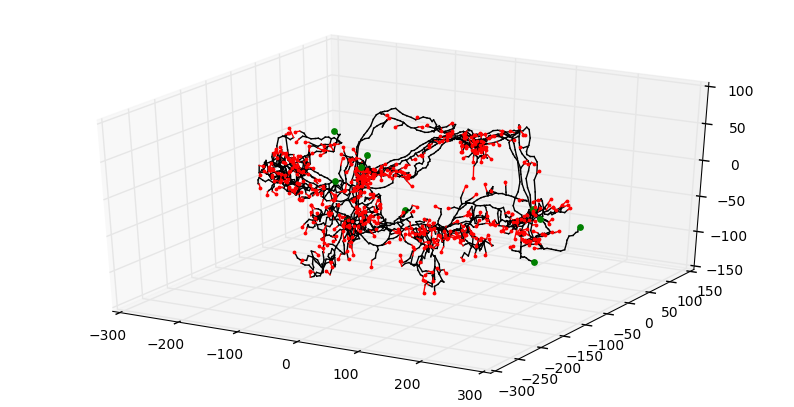

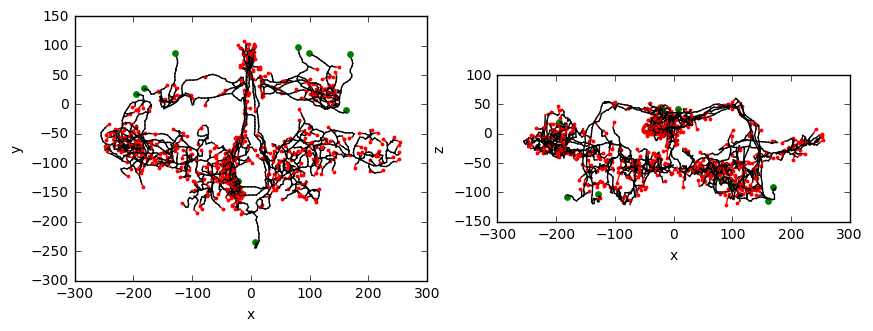

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize']=(10,5)

typecolors = {abi.Morphology.SOMA:'g',abi.Morphology.AXON:'k',\
              abi.Morphology.BASAL_DENDRITE:'b', abi.Morphology.APICAL_DENDRITE:'r'}
typesizes = {abi.Morphology.SOMA:15,abi.Morphology.AXON:1,\
              abi.Morphology.BASAL_DENDRITE:20, abi.Morphology.APICAL_DENDRITE:3}

ax = [None,None,None]
fig1 = plt.figure()
ax[0] = fig1.add_subplot(111,projection='3d')
fig2 = plt.figure()
ax[1] = fig2.add_subplot(1,2,1,aspect='equal')
ax[2] = fig2.add_subplot(1,2,2,aspect='equal')

for i in log_progress(range(10),every=1):
    morphology = FlyCircuitDB["neurons"][i]["swc"]
    for n in morphology.compartment_list:
        cval = typecolors.get(n['type'],'gray')  #color, default is gray
        sval = typesizes.get(n['type'],10)
        if (n['type']==abi.Morphology.SOMA) or (n['type']==abi.Morphology.APICAL_DENDRITE):
            ax[0].scatter([n['x']],[n['y']],[n['z']],s=sval,color=cval,marker='o')
            ax[1].scatter([n['x']],[n['y']],s=sval,color=cval,marker='o')
            ax[2].scatter([n['x']],[n['z']],s=sval,color=cval,marker='o')
        for c in morphology.children_of(n):
            cval = typecolors.get(c['type'],'gray')  #color, default is gray
            ax[0].plot([n['x'], c['x']], [n['y'], c['y']], [n['z'], c['z']], color=cval)
            ax[1].plot([n['x'], c['x']], [n['y'], c['y']], color=cval)
            ax[2].plot([n['x'], c['x']], [n['z'], c['z']], color=cval)


ax[0].set_zlim3d([-150,100])
ax[0].set_xlim3d([-300,300])
ax[0].set_ylim3d([-300,150])

ax[1].set_xlabel('x')
ax[1].set_ylabel('y')

ax[2].set_xlabel('x')
ax[2].set_ylabel('z')

plt.show()


total_length = 78849.116219
Going to build the dendrogram. This might take a while...
i am expanding the root
1.387364387512207  later the dendrogram was finished. 
max_widht=2680.000000, max_height=1817.995341


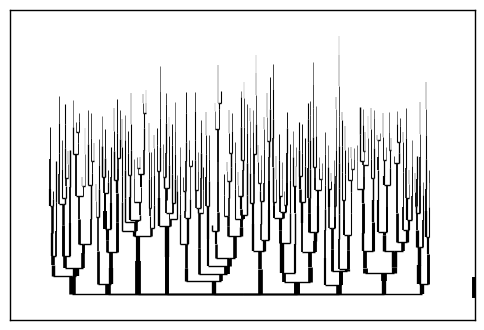

In [10]:
%matplotlib inline
import btmorph
import numpy
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.join(os.getcwd(),"btmorph"))
import btmorph

swc_tree= btmorph.STree2()
swc_tree.read_SWC_tree_from_file("btmorph_old/examples/data/v_e_moto1.CNG.swc")

stats = btmorph.BTStats(swc_tree)

# get the total length
total_length = stats.total_length()
print("total_length = %f" % total_length)

# get the max degree, i.e., degree of the soma
max_degree = stats.degree_of_node(swc_tree.get_root())

# generate and save the dendrogram
btmorph.plot_dendrogram("btmorph_old/examples/data/v_e_moto1.CNG.swc")

In [3]:
import os
import sys
import numpy as np

datadir = os.getcwd()

T =[-0.6224,-0.0087,0.0062,0.0077,-0.5265,-0.0941,-0.0112,0.1214,-0.4079,284.3,95.7,46.2];

T01747 = [0.344, -0.001, -0.023, 0.003, 0.344, 0.031, -0.064, 0.088, -0.960, 104.939, -28.676, 116.80];

morphology = load_swc(os.path.join(datadir,"../flyimages/swcs/01747.swc"))
morphology.apply_affine(T01747);
#morphology.apply_affine(T)
morphology.write("npfM200000_warped.swc")

T01748 = [0.345, 0.010, -0.001, -0.009, 0.344, 0.029, -0.006, 0.082, -0.962, 120.586, -56.695, 93.334];
morphology = load_swc(os.path.join(datadir,"../flyimages/swcs/01748.swc"))
morphology.apply_affine(T01748);
#morphology.apply_affine(T)
morphology.write("npfM300001_warped.swc")



